<a href="https://colab.research.google.com/github/clopensesame/Nazzaro_DSPN_S24/blob/main/Exercise_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 9: Classification

This homework assignment is designed to give you practice with classification models. We'll try to predict which words are more likely to be responded to correctly during a lexical decision task, based on their length and frequency.

We will be using data from the English Lexicon Project again. However, this time we will use response correctness as our dependent variable. Load **LexicalData_withIncorrect.csv**, which includes incorrect trials as well as correct ones, and also **Items.csv**. Both can be found in the *Homework/lexDat* folder in the class GitHub repository.

This data is a subset of the [English Lexicon Project database](https://elexicon.wustl.edu/). It provides response correctness and reaction times (in milliseconds) of many subjects as they are presented with letter strings and asked to decide, as quickly and as accurately as possible, whether the letter string is a word or not. The **Items.csv** provides characteristics of the words used, namely frequency (how common is this word?) and length (how many letters?).

*Data courtesy of Balota, D.A., Yap, M.J., Cortese, M.J., Hutchison, K.A., Kessler, B., Loftis, B., Neely, J.H., Nelson, D.L., Simpson, G.B., & Treiman, R. (2007). The English Lexicon Project. Behavior Research Methods, 39, 445-459.*

---
## 1. Loading and formatting the data (1 point)

Load in data from the **LexicalData_withIncorrect.csv** and **Items.csv** files. Use `left_join` to add word characteristics `Length` and `Log_Freq_Hal` from **Items** to the **LexicalData**, and use `drop_na()` to get rid of any observations with missing values. Then use `head()` to look at the first few rows of the data.

*Note: We're just working with `Correct` in this homework, so no need to worry about reformatting reaction times.*

In [61]:
install.packages(c("class","tidyverse","dplyr"))
library(class)
library(tidyverse)
library(dplyr)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [62]:
#files on desktop
dat <- read.csv("/content/LexicalData_withIncorrect.csv")
d1 <- read.csv("/content/Items.csv")

df <- data.frame(Length = d1$Length, Log_Freq_HAL = d1$Log_Freq_HAL, Word = d1$Word)

dat <- dat %>%
  left_join(df, by = c("D_Word" = "Word")) %>%
  drop_na()

head(dat)

,X,Sub_ID,Trial,Type,D_RT,D_Word,Outlier,D_Zscore,Correct,Length,Log_Freq_HAL
,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>
1,1,157,1,1,710,browse,false,-0.437,1,6,8.856
2,2,67,1,1,"1,094",refrigerant,false,0.825,1,11,4.644
3,3,120,1,1,587,gaining,false,-0.645,1,7,8.304
4,4,21,1,1,984,cheerless,false,0.025,1,9,2.639
5,5,236,1,1,577,pattered,false,-0.763,1,8,1.386
6,6,236,2,1,715,conjures,false,-0.364,1,8,5.268


---
## 2. Visualizing the data (1 point)

First, we'll try to visualize whether trials that are responded to correctly versus incorrectly differ from each other in terms of word length and log frequency. The code is included below, so that this homework doesn't get too cumbersome. All you have to do is **change the name of the data set**, **run the code**, and **write some observations about the output**.

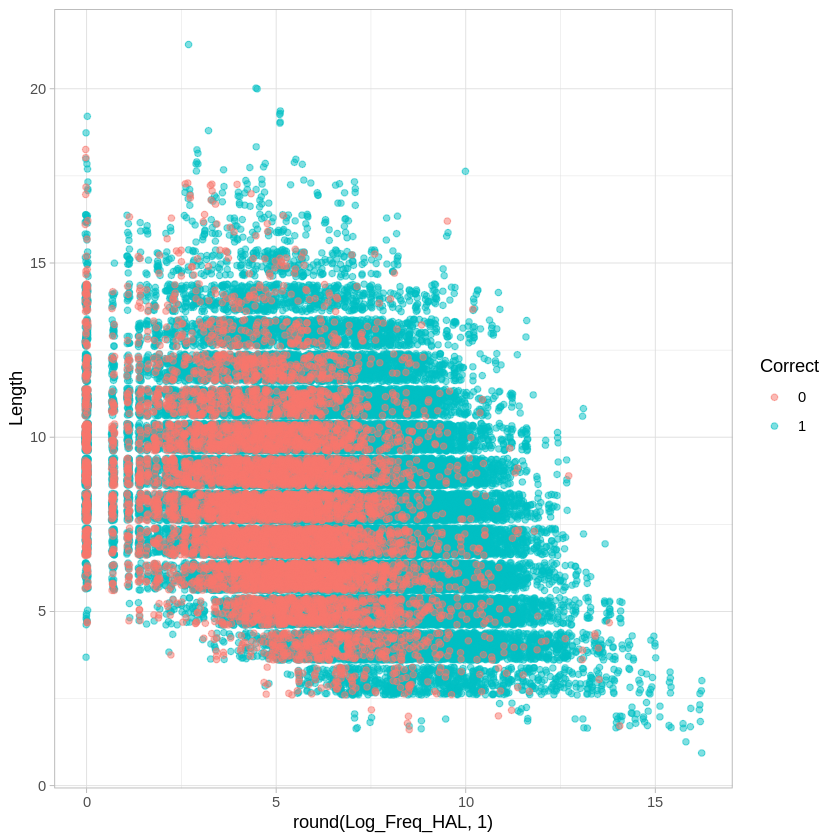

In [63]:
require(tidyverse) # Load the tidyverse package, if you haven't yet
dat$Correct <- as.factor(dat$Correct) # so that R knows that Correct is categorical, not numeric.

# plot the Correct / Incorrect clusters
ggplot(dat,aes(x=round(Log_Freq_HAL,1),y=Length,col=Correct)) + geom_point(position="jitter",alpha=0.5) + theme_light()


What do you observe about the "Correct" and "Incorrect" clusters?

> Incorrect and Correct clusters have similar lower bounds on Length (3)* and Log_Freq_HAL (0), but Correct has higher bounds than Incorrect clusters on Length (20, 17) and Log_Freq_HAL (15, 10). Due to this, Incorrect appears to be concentrated in a smaller area than Correct. In both cases, there appears to be a negative correlation between Log_Freq_HAL and Length.
>
> **numbers in () are very approximate*

---
## 3. Logistic Regression: Fitting the model (2 points)

Fit a logistic regression model to the data using `Length`, `Log_Freq_HAL`, and their interaction to predict `Correct`. Use `glm()` to fit the model, and look at its output using `summary()`.

In [64]:
# Run the GLM
#logistic regression = binomial
glm.fit=glm(Correct~Length*Log_Freq_HAL, data=dat, family=binomial)
summary(glm.fit)


Call:
glm(formula = Correct ~ Length * Log_Freq_HAL, family = binomial, 
    data = dat)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.939996   0.115623  -8.130 4.30e-16 ***
Length               0.151266   0.012789  11.828  < 2e-16 ***
Log_Freq_HAL         0.394772   0.018762  21.041  < 2e-16 ***
Length:Log_Freq_HAL -0.010558   0.002202  -4.795 1.63e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 49809  on 70588  degrees of freedom
Residual deviance: 46563  on 70585  degrees of freedom
AIC: 46571

Number of Fisher Scoring iterations: 5


What can you conclude from this output? (a brief gist is fine)

> At alpha = 0.001, we conclude that Length, Log_Freq_HAL, and the interaction between the two are all significant predictors of whether a trial is responded to correctly. Coefficients are as follows: Intercept = -0.94, Length Coef = 0.15, Log_Freq_HAL Coef = 0.39, Length:Log_Freq_HAL Coef = -0.01
>

---
## 4. Interpreting predictions from the model (3 points)

Finally, look at how well this logistic regression model does at predicting correctness. Use `predict()` and a threshold of 0.5 to generate predicted `Correct` values for each trial, then output a confusion matrix and overall accuracy for these predictions.

*Hint: see the Classifiers tutorial.*

In [106]:
glm_prob_df <- data.frame(predict(glm.fit, type = "response",threshold = 0.5))
colnames(glm_prob_df) = c('predicted_prob')
#0 = Incorrect, 1 = Correct
num_observations = nrow(glm_prob_df)
glm_prob_df$predicted_binary=rep(0,num_observations)
glm_prob_df$predicted_binary[glm_prob_df$predicted_prob>0.5]=1

confusion_df = data.frame(glm_prob_df_binary$predicted_binary, dat$Correct)
colnames(confusion_df) = c('predicted', 'actual')
table(confusion_df)
print(paste("Accuracy:",mean(confusion_df$predicted == confusion_df$actual)))

         actual
predicted     0     1
        0    13    44
        1  7966 62566

[1] "Accuracy: 0.886526229299183"


In [135]:
#sanity check
cor <- nrow(dat[dat$Correct == 1, ])
incor <- nrow(dat[dat$Correct == 0, ])
cor+incor
cor/(cor+incor) #Correct/Total
incor/(cor+incor) #Incorrect/Total
(7966+62566)/(cor+incor) #Predicted Correct
13/incor #Predicted Incorrect/Total Incorrect
(13+44)/(cor+incor) #Predicted Incorrect

[1] 70589

[1] 0.8869654

[1] 0.1130346

[1] 0.9991925

[1] 0.001629277

[1] 0.0008074913

Did the model do well at predicting lexical decision correctness? Why or why not?

> I think it did well since Accuracy = 88.65%. One reason why it did so well is that we are predicting accuracy on the same data our model used. Another reason why is because a significant portion of the dataset (88.70%) is Correct, so any model that predicts above 0.5 most of the time would likely perform pretty well. Ours predicted Correct 99.92% of the time, so it definitely falls into the "predicts above 0.5 most of the time" category. Another possible but less likely reason is that, since our coefficients were all significant, we are using good predictors/ not basing predictions on insignificant values that could make our predictions less accurate.

## 5. QDA (3 points)

Load in the `MASS` library and fit a QDA model to the data set. The predictors are still `Length`, `Log_Freq_HAL`, and their interaction, just like the logistic regression model you just ran, and the dependent variable is still `Correct`.

*Hint: see the Classifiers tutorial.*

In [ ]:
library(MASS)

In [100]:
qda.fit <-  qda(Correct~Length*Log_Freq_HAL, data=dat)
qda.class <- predict(qda.fit, dat)$class

Now look at how well the predicted `Correct` values compare with actual `Correct` values for the whole data set. Output a confusion matrix and overall prediction accuracy.

In [107]:
confusion_df = data.frame(qda.class, dat$Correct)
colnames(confusion_df) = c('predicted', 'actual')
table(confusion_df)
print(paste("Accuracy:",mean(qda.class == dat$Correct)))

         actual
predicted     0     1
        0   455  1647
        1  7524 60963

[1] "Accuracy: 0.870078907478502"


In [136]:
#sanity check
cor <- nrow(dat[dat$Correct == 1, ])
incor <- nrow(dat[dat$Correct == 0, ])
cor+incor
cor/(cor+incor) #Correct/Total
incor/(cor+incor) #Incorrect/Total
(7524+60963)/(cor+incor) #Predicted Correct/Total
455/incor #Predicted Incorrect/Total Incorrect
(455+1647)/(cor+incor) #Predicted Incorrect/Total

[1] 70589

[1] 0.8869654

[1] 0.1130346

[1] 0.970222

[1] 0.05702469

[1] 0.02977801

How does QDA prediction performance differ from that of logistic regression?

> QDA had a slightly lower predictive accuracy than logistic regression, but rather than predicting Correct 99.92% of the time and Incorrect 0.08% of the time, QDA predicted Correct 97.02% of the time and Incorrect 2.98% of the time, which is closer to the true division of 88.70% Correct and 11.30% Incorrect.
Furthermore, in regression, we accurately predicted only 0.2% of Incorrects, whereas in QDA we accurately predicted 5.7% of Incorrects. This coupled with the fact that accuracy did not change much, could potentially indicate that the QDA model is more accurately capturing the overall relationship and is not overfitted to our data.

**DUE:** 5pm EST, March 11, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> *Someone's Name*